## Environment Setup

In [10]:
import os

import pandas as pd

import json
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt

/Users/santan/workspace/torchspace/venv/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
from enum import Enum

class RunningEnv(Enum):
    LOCAL = 1
    COLAB = 2
    KAGGLE = 3
ENV = RunningEnv.LOCAL

if ENV == RunningEnv.LOCAL:
    cwd = os.getcwd()
    source_data_path = os.path.join(cwd, 'data', 'js_data')
    working_dir = os.path.join(cwd, 'data', 'working')
elif ENV == RunningEnv.KAGGLE:
    source_data_path = '/kaggle/input/jane-street-real-time-market-data-forecasting'
    working_dir = '/kaggle/working'
elif ENV == RunningEnv.COLAB:
    print('running Colab')
    source_data_path = '/data/jane-street-real-time-market-data-forecasting'
    working_dir = '/working'
else:
    raise ValueError('Invalid environment')
print(f'The environment: {ENV}')
print(f'workding directory: {working_dir}')
print(f'source data directory is: {source_data_path}')

ALL_FEATURES = [f"feature_{i:02}" for i in range(79)]
FEATURE_RESPONDERS = [f'responder_{i}' for i in range(9)]

all_partitions = [f'partition_id={i}' for i in range(10)]

training_data_path = os.path.join(source_data_path, 'train.parquet')
processed_training_data_path = os.path.join(source_data_path, 'processed_train.parquet')
testing_data_path = os.path.join(source_data_path, 'test.parquet', 'date_id=0', 'part-0.parquet')

The environment: RunningEnv.LOCAL
workding directory: /Users/santan/workspace/torchspace/data/working
source data directory is: /Users/santan/workspace/torchspace/data/js_data


## Data Overall Study

- there are 47,127,338 rows, 39 unique symbols, and 1699 unique days
- before (inclusive) the date of `676`, there are 849 unique time ids per day; after that date, there are 968 unique time ids per day. Given we have plenty of day, we may choose to skip the data before date `678`
- the date of `676` appears in the partition 3; therefore, **we may choose to skip the data before (inclusive) partition 3**
- there are lots of NaN values in different columns, therefore **we cannot simply skip the records with null values**

In [100]:
train_data_df = dd.read_parquet(training_data_path)


In [16]:
print(f'Train data size: {train_data_df.shape[0].compute()}')

Train data size: 47127338


In [20]:
print(f'Unique number of symbols: {train_data_df.symbol_id.nunique().compute()}')

Unique number of symbols: 39


In [18]:
print(f'Unique number of days: {train_data_df.date_id.nunique().compute()}')

Unique number of days: 1699


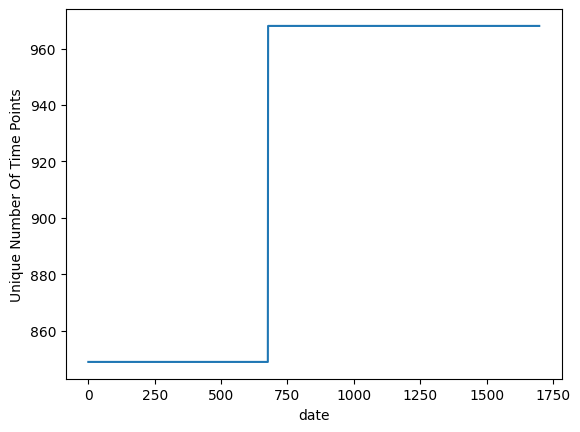

In [25]:
time_id_per_day = train_data_df.groupby(['date_id'])['time_id'].nunique().compute()

plt.xlabel('date')
plt.ylabel('Unique Number Of Time Points')
plt.plot(time_id_per_day)

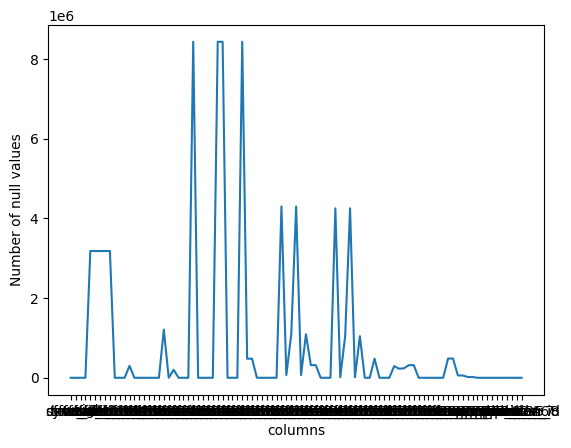

In [26]:
null_counts = train_data_df.isnull().sum().compute()

plt.xlabel('columns')
plt.ylabel('Number of null values')
plt.plot(null_counts)

## Symbol Specific Analysis

- there are **date gaps** in the data, therefore we need to take care of the missing dates for feature engineering
- there is **no time id gaps** for a given date

In [27]:
valid_partitions = ['partition_id=4', 'partition_id=5', 'partition_id=6', 'partition_id=7', 'partition_id=8', 'partition_id=9']

def pd_load_data(partitions):
    loaded_dfs = []
    for p in partitions:
        tmp_df = pd.read_parquet(
            os.path.join(training_data_path, p))
        loaded_dfs.append(tmp_df)
        del tmp_df
    
    data = pd.concat(loaded_dfs)
    del loaded_dfs
    
    return data

In [29]:
partition_8_9_df = pd_load_data(partitions=['partition_id=8', 'partition_id=9'])

<BarContainer object of 39 artists>

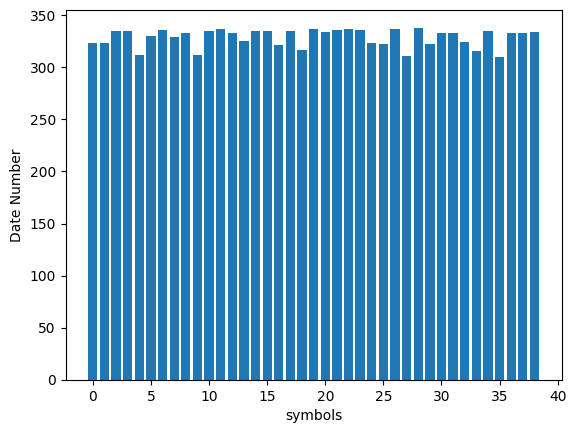

In [37]:

sym_date_count = partition_8_9_df.groupby(['symbol_id'])['date_id'].nunique()

plt.xlabel('symbols')
plt.ylabel('Date Number')
plt.bar(sym_date_count.index, sym_date_count.values)

date id of symbol 5 (date 1391 and 1392 missing): Index([1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371,
       1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383,
       1384, 1385, 1386, 1387, 1388, 1389, 1390, 1393, 1394, 1395, 1396, 1397,
       1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409,
       1410, 1411],
      dtype='int16', name='date_id')


<BarContainer object of 330 artists>

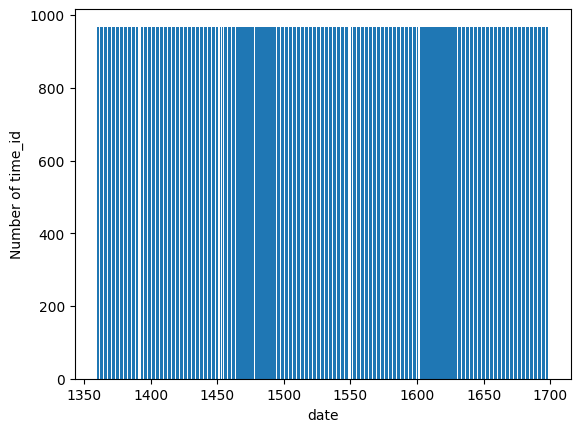

In [45]:
symbol = 5

sym_5_date_time_points = partition_8_9_df[partition_8_9_df['symbol_id'] == symbol].groupby(['date_id'])['time_id'].nunique()

print(f'date id of symbol {symbol} (date 1391 and 1392 missing): {sym_5_date_time_points.index[:50]}')
plt.xlabel('date')
plt.ylabel('Number of time_id')
plt.bar(sym_5_date_time_points.index, sym_5_date_time_points.values)

## Feature Analysis

- `feature_73` to `feature_78` are correlated to each other (all correlation scores above 0.75)
    - `feature_73` and `feature_74` are highly correlated (above 0.95)
    - `feature_75` and `feature_76` are highly correlated (above 0.95)
    - `feature_77` and `feature_78` are highly correlated (above 0.95)
- `feature_00`, `feature_02`, and `feature_03` are very correlated (scores above 0.95)
- `feature_32`, `feature_34`, and `feature_35` are very correlated (scores above 0.90)
- `feature_12`, `feature_67`, and `feature_70` are very correlated (scores above 0.90)
- `feature_14`, `feature_69`, and `feature_72` are very correlated (scores above 0.90)

In [46]:
del partition_8_9_df

partition_9_df = pd_load_data(partitions=['partition_id=9'])


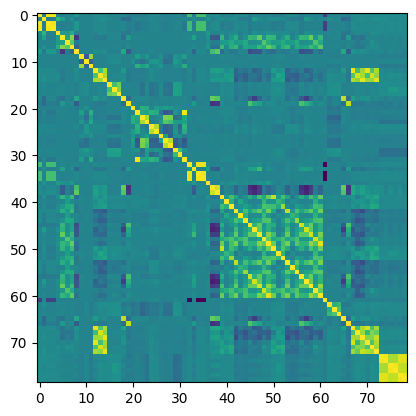

In [48]:
correlation_matrix = partition_9_df[ALL_FEATURES].corr()
plt.imshow(correlation_matrix)
plt.show()

In [49]:
correlation_matrix.iloc[65:, 65:]

,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
feature_65,1.000000,-0.167178,0.206377,0.047378,0.110398,0.103822,0.011475,0.045664,0.000733,-0.045756,0.021148,-0.021151,0.009161,-0.034505
feature_66,-0.167178,1.000000,-0.093652,-0.082177,-0.097456,-0.019067,-0.062684,-0.053970,-0.087513,-0.040193,-0.065373,-0.022042,-0.079220,-0.034886
feature_67,0.206377,-0.093652,1.000000,0.465810,0.760466,0.892332,0.470782,0.737026,0.036698,0.009201,0.029574,0.004158,0.027540,0.001657
feature_68,0.047378,-0.082177,0.465810,1.000000,0.725564,0.393993,0.665412,0.573116,0.049909,0.035520,0.084158,0.071433,0.069400,0.056376
feature_69,0.110398,-0.097456,0.760466,0.725564,1.000000,0.667509,0.661426,0.838124,0.064281,0.043513,0.063613,0.044315,0.066564,0.046991
feature_70,0.103822,-0.019067,0.892332,0.393993,0.667509,1.000000,0.481780,0.774953,0.027862,0.014184,0.013871,0.000985,0.013837,0.000965
feature_71,0.011475,-0.062684,0.470782,0.665412,0.661426,0.481780,1.000000,0.732817,0.053505,0.045732,0.088715,0.082037,0.075054,0.068228
feature_72,0.045664,-0.053970,0.737026,0.573116,0.838124,0.774953,0.732817,1.000000,0.063978,0.053461,0.053140,0.043247,0.061797,0.051784
feature_73,0.000733,-0.087513,0.036698,0.049909,0.064281,0.027862,0.053505,0.063978,1.000000,0.957587,0.767756,0.762053,0.920212,0.915861
feature_74,-0.045756,-0.040193,0.009201,0.035520,0.043513,0.014184,0.045732,0.053461,0.957587,1.000000,0.760966,0.764247,0.913385,0.918872


In [50]:
correlation_matrix.iloc[30:40, 30:40]

,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39
feature_30,1.000000,-0.005508,0.005286,-0.002571,0.005668,0.005842,0.000620,0.008784,0.005864,0.024988
feature_31,-0.005508,1.000000,-0.005895,-0.014515,-0.002142,-0.002644,-0.002325,-0.006204,-0.002079,0.033746
feature_32,0.005286,-0.005895,1.000000,0.093415,0.934920,0.936676,0.032700,-0.018382,-0.008181,-0.017860
feature_33,-0.002571,-0.014515,0.093415,1.000000,-0.030413,-0.024609,0.184065,-0.251881,-0.290015,0.058947
feature_34,0.005668,-0.002142,0.934920,-0.030413,1.000000,0.953432,-0.009083,0.013180,0.029602,-0.024833
feature_35,0.005842,-0.002644,0.936676,-0.024609,0.953432,1.000000,0.018543,0.012448,0.028900,-0.022011
feature_36,0.000620,-0.002325,0.032700,0.184065,-0.009083,0.018543,1.000000,-0.014392,-0.013756,0.107502
feature_37,0.008784,-0.006204,-0.018382,-0.251881,0.013180,0.012448,-0.014392,1.000000,0.865627,-0.113365
feature_38,0.005864,-0.002079,-0.008181,-0.290015,0.029602,0.028900,-0.013756,0.865627,1.000000,-0.108419
feature_39,0.024988,0.033746,-0.017860,0.058947,-0.024833,-0.022011,0.107502,-0.113365,-0.108419,1.000000


In [51]:
correlation_matrix.iloc[0:5, 0:5]

,feature_00,feature_01,feature_02,feature_03,feature_04
feature_00,1.000000,0.003824,0.952618,0.954073,0.019684
feature_01,0.003824,1.000000,-0.047512,-0.038848,0.377856
feature_02,0.952618,-0.047512,1.000000,0.956403,-0.019407
feature_03,0.954073,-0.038848,0.956403,1.000000,0.000838
feature_04,0.019684,0.377856,-0.019407,0.000838,1.000000


In [52]:
correlation_matrix.iloc[65:75, 10:15]

,feature_10,feature_11,feature_12,feature_13,feature_14
feature_65,0.005835,0.008500,0.160167,0.032774,0.082038
feature_66,-0.005159,-0.000843,-0.058972,-0.079112,-0.079635
feature_67,-0.012946,-0.000913,0.944493,0.503741,0.773339
feature_68,-0.006343,-0.000710,0.438344,0.886443,0.674862
feature_69,-0.009591,-0.001285,0.726734,0.748487,0.931322
feature_70,-0.013658,-0.011783,0.941539,0.469878,0.741380
feature_71,-0.007213,-0.006238,0.483588,0.874025,0.718806
feature_72,-0.010343,-0.009112,0.768956,0.698758,0.927618
feature_73,0.030902,-0.063409,0.033041,0.056498,0.066202
feature_74,0.030853,-0.064649,0.011881,0.044169,0.049924


## Forecast Target Analysis

- the value is in the range of -5 to 5
- the value distribution is close to a normal distribution
- there is **a strong recent trend** in the values, which means the current value is strongly correlated with recent values. The following shows an example correlations with the values at 1/2/4/8/16/32/64/128/256 steps ahead. **There seems little correlation with values beyond 64 steps ahead**. However, this only represent linear correlation.

| responder_6 | offset_1 | offset_2 | offset_4 | offset_8 | offset_16 | offset_32 | offset_64 | offset_128 | offset_256
| ---         | ---      | ---      |---       | ---      | ---       |---        | ---       | ---        |---  |
| 1.0000      | 0.8952   |	0.8534  | 0.7584   | 0.5671   | 0.2234    | 0.0903    | -0.0176   | 0.0034     | -0.0315 |

- there is **no daily/weekly pattern** of the values (by checking the correlation; the correlation of daily value is less than 0.2)

Text(0, 0.5, 'occurence')

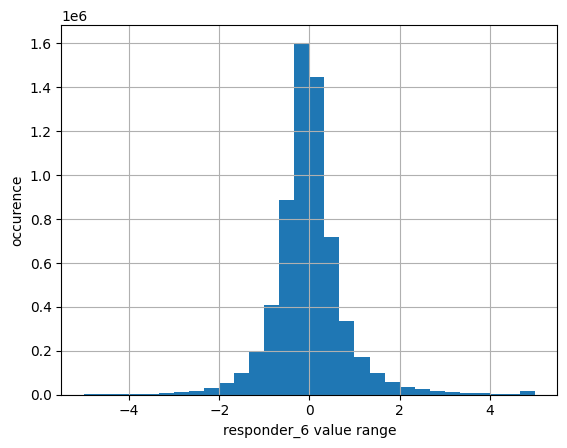

In [55]:

# partition_9_df = pd_load_data(partitions=['partition_id=9'])

partition_9_df['responder_6'].hist(bins=30)
plt.xlabel('responder_6 value range')
plt.ylabel('occurence')

Text(0, 0.5, 'occurence')

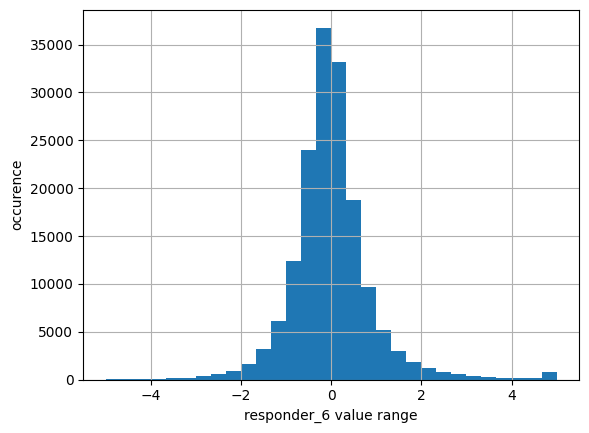

In [56]:
symbol = 2

partition_9_df[partition_9_df['symbol_id'] == symbol]['responder_6'].hist(bins=30)
plt.xlabel('responder_6 value range')
plt.ylabel('occurence')

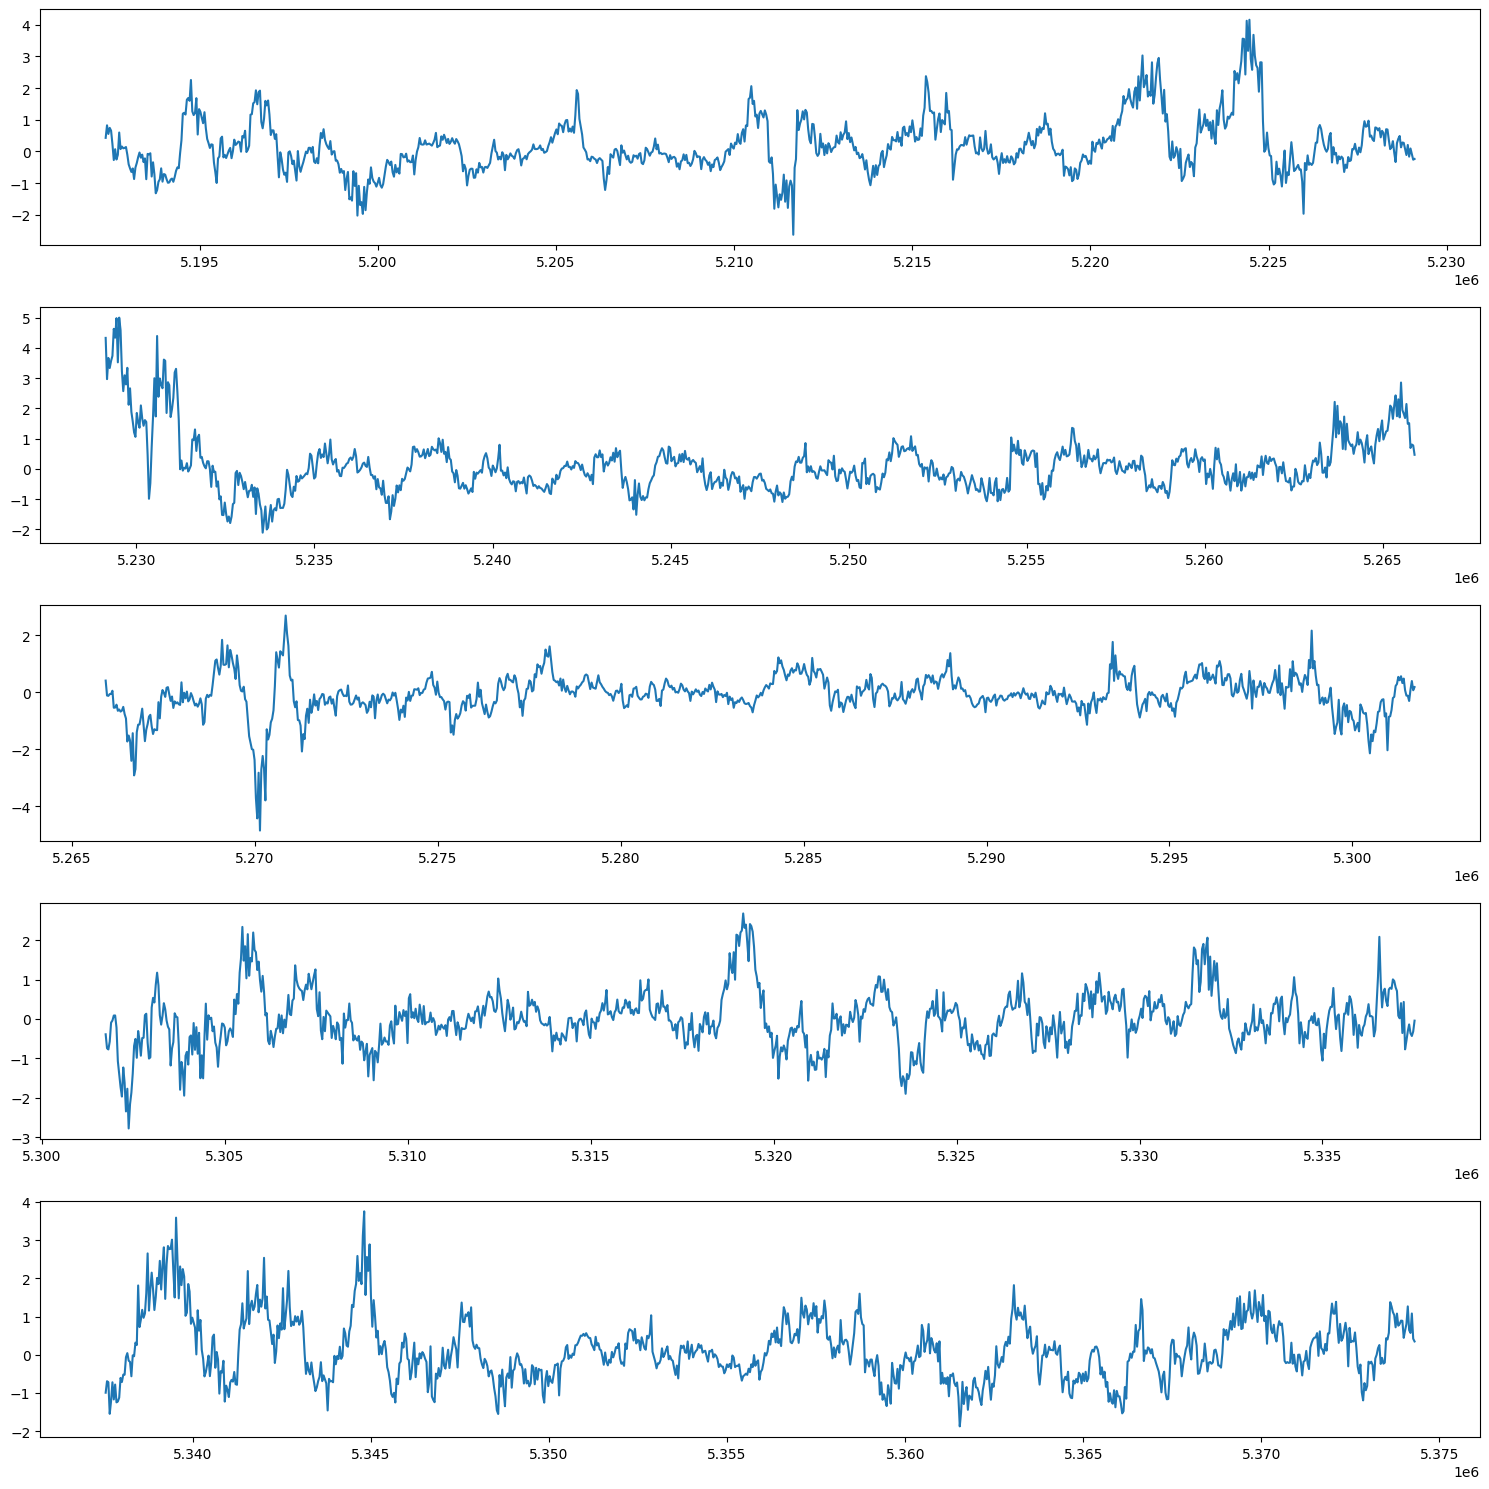

In [74]:
symbol = 2
sym_df = partition_9_df[partition_9_df['symbol_id'] == symbol]

total_dates = 5
fig, axs = plt.subplots(total_dates, 1, figsize=(15, 3 * total_dates))

for i in range(total_dates):
    data = sym_df[sym_df['date_id'] == (1670 + i)]['responder_6']
    axs[i].plot(data)

plt.tight_layout()  # Adjust subplot spacing
plt.show()

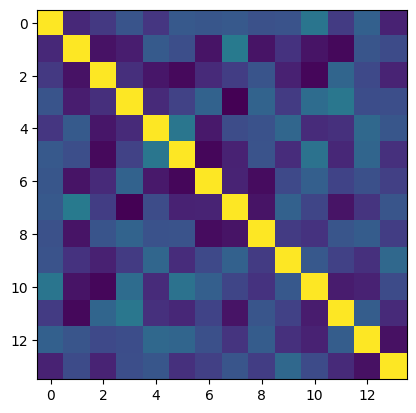

In [87]:
dates = [1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683]

symbol = 2
sym_df = partition_9_df[partition_9_df['symbol_id'] == symbol]

limited_dates_data = sym_df[sym_df['date_id'].isin(dates)]

daily_cols = limited_dates_data.pivot(index='time_id', columns='date_id', values='responder_6')
dates_corr = daily_cols.corr()

plt.imshow(dates_corr)
plt.show()

In [88]:
dates_corr

date_id,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,1683
date_id,,,,,,,,,,,,,,
1670,1.000000,-0.097475,-0.033582,0.085022,-0.044315,0.108976,0.094718,0.107270,0.070011,0.080053,0.240390,-0.025384,0.142580,-0.121223
1671,-0.097475,1.000000,-0.176369,-0.141912,0.112935,0.056541,-0.173773,0.271483,-0.172218,-0.056145,-0.173203,-0.214301,0.088801,0.042714
1672,-0.033582,-0.176369,1.000000,-0.071689,-0.164322,-0.206064,-0.090313,-0.014699,0.080517,-0.127614,-0.219527,0.163310,0.032849,-0.114307
1673,0.085022,-0.141912,-0.071689,1.000000,-0.089393,0.004569,0.149168,-0.239057,0.155683,-0.025105,0.198568,0.253140,0.056068,0.058315
1674,-0.044315,0.112935,-0.164322,-0.089393,1.000000,0.245249,-0.153539,0.047329,0.072358,0.167519,-0.087346,-0.066470,0.180990,0.091559
1675,0.108976,0.056541,-0.206064,0.004569,0.245249,1.000000,-0.216620,-0.118732,0.075903,-0.083240,0.228000,-0.100574,0.166996,-0.065125
1676,0.094718,-0.173773,-0.090313,0.149168,-0.153539,-0.216620,1.000000,-0.114748,-0.197085,0.035254,0.135404,0.009886,0.061039,-0.003388
1677,0.107270,0.271483,-0.014699,-0.239057,0.047329,-0.118732,-0.114748,1.000000,-0.174539,0.144749,0.020853,-0.173881,-0.050893,0.089294
1678,0.070011,-0.172218,0.080517,0.155683,0.072358,0.075903,-0.197085,-0.174539,1.000000,-0.022524,-0.056465,0.089009,0.123653,-0.015369


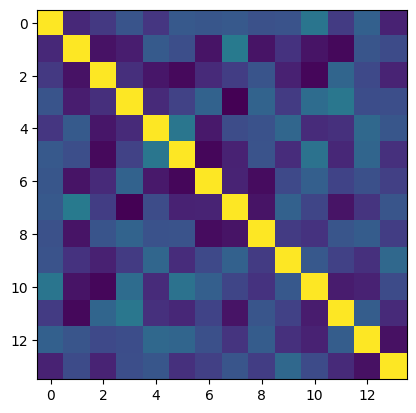

In [97]:
symbol = 2
sym_df = partition_9_df[partition_9_df['symbol_id'] == symbol]

offset_df = sym_df[sym_df['date_id'].isin([1670, 1671, 1672])][['responder_6']]
offsets = [1, 2, 4, 8, 16, 32, 64, 128, 256]
for os in offsets:
    offset_df[f'resp_6_{os}'] = offset_df['responder_6'].shift(os)
    
offset_corr = offset_df.corr()

plt.imshow(dates_corr)
plt.show()

In [98]:
offset_corr

,responder_6,resp_6_1,resp_6_2,resp_6_4,resp_6_8,resp_6_16,resp_6_32,resp_6_64,resp_6_128,resp_6_256
responder_6,1.000000,0.895222,0.853415,0.758461,0.567191,0.223434,0.090396,-0.017631,0.003442,-0.031560
resp_6_1,0.895222,1.000000,0.895224,0.800514,0.613817,0.256222,0.088181,-0.010906,-0.010287,-0.024585
resp_6_2,0.853415,0.895224,1.000000,0.853422,0.667932,0.299159,0.094441,-0.014634,-0.019299,-0.021172
resp_6_4,0.758461,0.800514,0.853422,1.000000,0.758576,0.384290,0.099974,-0.009899,-0.037544,-0.017365
resp_6_8,0.567191,0.613817,0.667932,0.758576,1.000000,0.567384,0.083913,-0.014476,-0.063028,0.011480
resp_6_16,0.223434,0.256222,0.299159,0.384290,0.567384,1.000000,0.224971,0.014478,-0.118509,0.104408
resp_6_32,0.090396,0.088181,0.094441,0.099974,0.083913,0.224971,1.000000,0.087731,-0.014238,0.110219
resp_6_64,-0.017631,-0.010906,-0.014634,-0.009899,-0.014476,0.014478,0.087731,1.000000,-0.015874,0.087722
resp_6_128,0.003442,-0.010287,-0.019299,-0.037544,-0.063028,-0.118509,-0.014238,-0.015874,1.000000,0.009327
resp_6_256,-0.031560,-0.024585,-0.021172,-0.017365,0.011480,0.104408,0.110219,0.087722,0.009327,1.000000


## Archive

In [91]:
import joblib
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(raw_df[ALL_FEATURES])

joblib.dump(scaler, 'data/working/feature_scaler.pkl')

['data/working/feature_scaler.pkl']

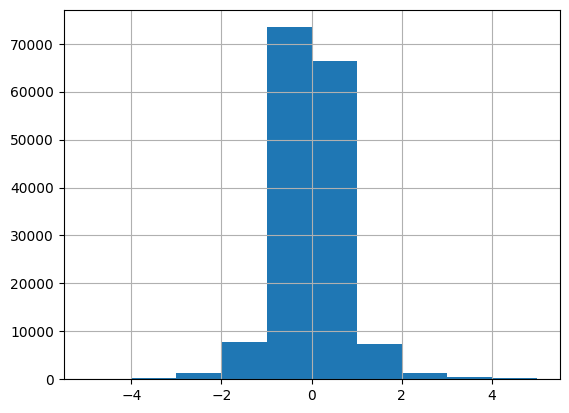

In [19]:
raw_df[raw_df['symbol_id'] == 0]['responder_6'].hist()

plt.show()

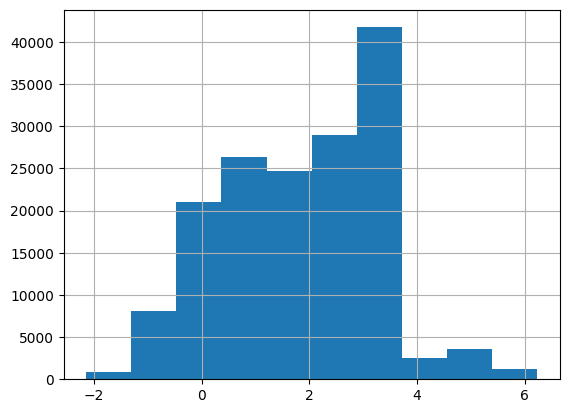

In [38]:
raw_df[raw_df['symbol_id'] == 0]['feature_02'].hist()

plt.show()

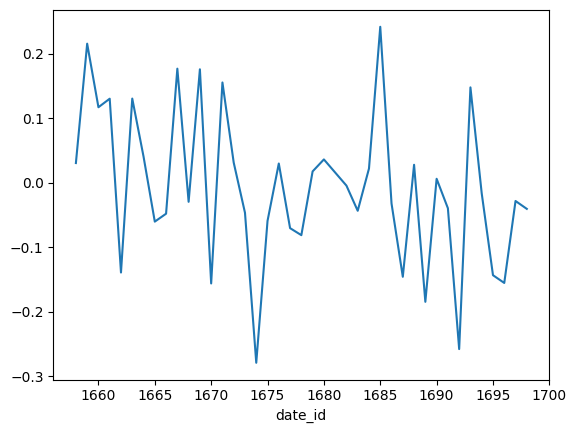

'\nsmoothed_daily_mean = daily_mean.rolling(window=4).mean()\nsmoothed_daily_mean.plot()\nplt.show()\n'

In [85]:
daily_mean = raw_df[raw_df['symbol_id'] == 0].groupby('date_id')['responder_6'].mean()[-40:]

# daily_mean.head(20)
daily_mean.plot()
plt.show()

'''
smoothed_daily_mean = daily_mean.rolling(window=4).mean()
smoothed_daily_mean.plot()
plt.show()
'''

In [12]:
raw_df[(raw_df['symbol_id'] == 0) & (raw_df['responder_6'] > 4.9)].count()

date_id        126
time_id        126
symbol_id      126
weight         126
feature_00     126
              ... 
responder_4    126
responder_5    126
responder_6    126
responder_7    126
responder_8    126
Length: 92, dtype: int64

In [ ]:
time_id_count = raw_df[['date_id', 'time_id']].groupby('date_id')['time_id'].nunique().compute()
print(time_id_count)

# time_id_count.to_csv(
#    os.path.join(working_dir, 'time_id_count.csv'))

In [22]:
partition_df = dd.read_parquet(os.path.join(training_data_path, 'partition_id=3', 'part-0.parquet'))
partition_df[['date_id', 'time_id']].groupby('date_id')['time_id'].nunique().compute()

date_id
510    849
511    849
512    849
513    849
514    849
      ... 
675    849
676    849
677    968
678    968
679    968
Name: time_id, Length: 170, dtype: int64

In [98]:

def gaps_in_time_series(col, col_name, partition, symbol=None):
    sorted_col = pd.Series(col.unique()).sort_values(ascending=True)
    shifted = sorted_col.shift(periods=1)
    delta = sorted_col - shifted
    gaps = (delta > 1)
    gaps_val = sorted_col[gaps]

    # print(gaps_val, gaps_val.shape[0], '\n')
    if gaps_val.shape[0] > 1:
        # print(f'sorted_col {sorted_col}\n')
        # print(f'gap shape {gaps_val.shape[0]}\n')
        print(f'detected gaps at partition ({partition}) symbol ({symbol})in column ({col_name}): {gaps_val} \n')
        return True

    # print(f'No gaps at partition ({partition}) symbol ({symbol})in column ()')
    return False


def gaps_in_time(df, partition):
    gaps_in_time_series(df['date_id'], 'date_id', partition)
    gaps_in_time_series(df['time_id'], 'time_id', partition)

    all_dates = df['date_id'].unique()
    all_symbols = df['symbol_id'].unique()

    count = 0
    for sym in all_symbols:
        slice_sym_df = df[df['symbol_id'] == sym]
        if gaps_in_time_series(slice_sym_df['date_id'], 'date_id', partition, symbol=sym):
            count += 1
            if count >= 5:
                break

        '''
        for date in all_dates:
            slice_df = slice_sym_df[df['date_id'] == date]
            gaps_in_time_series(slice_df['time_id'], 'time_id', partition, symbol=sym)
        '''

# partition_df = pd.read_parquet(os.path.join(training_data_path, 'partition_id=4', 'part-0.parquet'))
# gaps_in_time(partition_df, 3)

In [97]:
import numpy as np

partition_df = pd.read_parquet(os.path.join(training_data_path, 'partition_id=4'))

print('unique date ids: ', partition_df['date_id'].unique())

# print(partition_df[partition_df['symbol_id'] == sym]['date_id'].unique())

all_symbols = partition_df['symbol_id'].unique()

all_dates = set(partition_df['date_id'].unique())
count = 0
for sym in all_symbols:
    missing_days = all_dates - set(partition_df[partition_df['symbol_id'] == sym]['date_id'].unique())
    if len(missing_days) > 0:
        print(f'Symbol ({sym}) misses dates: {missing_days}')
        count += 1
        if count > 10:
            break
    else:
        print(f'Symbol ({sym}) has all dates')

unique date ids:  [680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697
 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715
 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733
 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751
 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769
 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787
 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805
 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823
 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847 848 849]
Symbol (0) misses dates: {np.int16(713), np.int16(714), np.int16(715), np.int16(716), np.int16(717), np.int16(718), np.int16(719), np.int16(720), np.int16(721), np.int16(722), np.int16(723), np.int16(724), np.int16(725), np.int16(726), np.int16(727), np.int16(728), np.int16(729), np.int16(7

## test data format
- `date_id` is not available in test input
- all features are not available, except `weight`
- submission requires `row_id` and `responder_6`

In [32]:
test_df = pd.read_parquet(testing_data_path, engine = 'fastparquet')

In [34]:
test_df['is_scored'].all()

np.False_

In [25]:
lags_data_path = os.path.join(source_data_path, 'lags.parquet', 'date_id=0', 'part-0.parquet')
lags_df = pd.read_parquet(lags_data_path, engine = 'fastparquet')
lags_df.head()

,date_id,time_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
0,0,0,0,-0.442215,-0.322407,0.143594,-0.926890,-0.782236,-0.036595,-1.305746,-0.795677,-0.143724
1,0,0,1,-0.651829,-1.707840,-0.893942,-1.065488,-1.871338,-0.615652,-1.162801,-1.205924,-1.245934
2,0,0,2,-0.656373,-0.264575,-0.892879,-1.511886,-1.033480,-0.378265,-1.574290,-1.863071,-0.027343
3,0,0,3,-0.188186,-0.190970,-0.701490,0.098453,-1.015506,-0.054984,0.329152,-0.965471,0.576635
4,0,0,4,-0.257462,-0.471325,-0.297420,0.074018,-0.324194,-0.597093,0.219856,-0.276356,-0.904790


In [29]:
len(lags_df.symbol_id.unique())

39

In [27]:
lags_df.time_id.unique()

array([0], dtype=int16)

In [16]:
test_df.head()

,row_id,time_id,symbol_id,weight,is_scored,feature_00,feature_01,feature_02,feature_03,feature_04,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,date_id
0,0,0,0,3.169998,False,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0
1,1,0,1,2.165993,True,0.0,-0.0,0.0,0.0,0.0,...,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0
2,2,0,2,3.065550,True,0.0,-0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0
3,3,0,3,2.698642,True,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0
4,4,0,4,1.803330,True,0.0,-0.0,0.0,0.0,0.0,...,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0


In [24]:
print(test_df['time_id'].unique())

[0]


In [17]:
sample_submission_df = pd.read_csv(
    os.path.join(source_data_path, 'sample_submission.csv'))
sample_submission_df.head()

,row_id,responder_6
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [36]:
import numpy as np

list_of_arrays = [np.array([1, 2, 3]), np.array([4, 5, 6])]
array = np.array(list_of_arrays)

print(array)


[[1 2 3]
 [4 5 6]]


In [37]:
import pytorch_lightning as L

In [38]:
print(L.LightningModule)

<class 'pytorch_lightning.core.module.LightningModule'>
